In [87]:
#! /usr/bin/env python
# -*- coding: utf-8 -*-
import pickle
import math

"""
Image deformation using moving least squares

@author: Jian-Wei ZHANG
@email: zjw.cs@zju.edu.cn
@date: 2017/8/8
@update: 2020/9/25
@update: 2021/7/14: Simplify usage
@update: 2021/12/24: Fix bugs and add an example of random control points (see `demo2()`)
"""

import time
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

try:
    import torch    # Install PyTorch first: https://pytorch.org/get-started/locally/
    from img_utils_pytorch import (
        mls_affine_deformation as mls_affine_deformation_pt,
        mls_similarity_deformation as mls_similarity_deformation_pt,
        mls_rigid_deformation as mls_rigid_deformation_pt,
    )
    device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

except ImportError as e:
    print(e)

from img_utils import (
    mls_affine_deformation, 
    mls_similarity_deformation, 
    mls_rigid_deformation
)

from PIL import Image


def demo():
    
    with open('./../SkeletonMatching/matched_points.pickle', 'rb') as handle:
        matched_points = pickle.load(handle, encoding='latin1')

    to_rm = []
    for key, val in matched_points.items():
        if math.dist(key, val) > 40:
            to_rm.append(key)

    for rm in to_rm: 
        del matched_points[rm]


    p = np.array([list(sr) for sr in list(matched_points.keys())])
    q = np.array([list(sr) for sr in list(matched_points.values())])

    image = np.array(Image.open("images/labels.png"))
    
    height, width, _ = image.shape
    gridX = np.arange(width, dtype=np.int16)
    gridY = np.arange(height, dtype=np.int16)
    vy, vx = np.meshgrid(gridX, gridY)
    
    affine = mls_affine_deformation(vy, vx, p, q, alpha=1)
    aug1 = np.ones_like(image)
    aug1[vx, vy] = image[tuple(affine)]

    similar = mls_similarity_deformation(vy, vx, p, q, alpha=1)
    aug2 = np.ones_like(image)
    aug2[vx, vy] = image[tuple(similar)]

    rigid = mls_rigid_deformation(vy, vx, p, q, alpha=1)
    aug3 = np.ones_like(image)
    aug3[vx, vy] = image[tuple(rigid)]

    fig, ax = plt.subplots(1, 4, figsize=(12, 4))
    ax[0].imshow(image)
    ax[0].set_title("Original Image")    
    ax[1].imshow(aug1)
    ax[1].set_title("Affine Deformation")
    ax[2].imshow(aug2)
    ax[2].set_title("Similarity Deformation")
    ax[3].imshow(aug3)
    ax[3].set_title("Rigid Deformation")

    for x in ax.flat:
        x.axis("off")

    plt.tight_layout(w_pad=0.1)
    plt.show()
    
    return image, aug2


def demo_torch():
    with open('./../SkeletonMatching/matched_points.pickle', 'rb') as handle:
        matched_points = pickle.load(handle, encoding='latin1')
    
    print(len(matched_points))
    
    to_rm = []
    for key, val in matched_points.items():
        if math.dist(key, val) > 100:
            to_rm.append(key)

    for rm in to_rm: 
        del matched_points[rm]
    
    p = torch.from_numpy(np.array([
                 list(sr) for sr in list(matched_points.keys())])).to(device)
    q = torch.from_numpy(np.array([
                 list(sr) for sr in list(matched_points.values())])).to(device)

    image = torch.from_numpy(np.array(Image.open("images/labels.png"))).to(device)

    height, width, _ = image.shape
    gridX = torch.arange(width, dtype=torch.int16).to(device)
    gridY = torch.arange(height, dtype=torch.int16).to(device)
    vy, vx = torch.meshgrid(gridX, gridY)
    # !!! Pay attention !!!: the shape of returned tensors are different between numpy.meshgrid and torch.meshgrid
    vy, vx = vy.transpose(0, 1), vx.transpose(0, 1)
    
    affine = mls_affine_deformation_pt(vy, vx, p, q, alpha=1)
    aug1 = torch.ones_like(image).to(device)
    aug1[vx.long(), vy.long()] = image[tuple(affine)]

    similar = mls_similarity_deformation_pt(vy, vx, p, q, alpha=1)
    aug2 = torch.ones_like(image).to(device)
    aug2[vx.long(), vy.long()] = image[tuple(similar)]

    rigid = mls_rigid_deformation_pt(vy, vx, p, q, alpha=1)
    aug3 = torch.ones_like(image).to(device)
    aug3[vx.long(), vy.long()] = image[tuple(rigid)]

    fig, ax = plt.subplots(1, 4, figsize=(12, 4))
    ax[0].imshow(image)
    ax[0].set_title("Original Image")    
    ax[1].imshow(aug1.cpu().numpy())
    ax[1].set_title("Affine Deformation")
    ax[2].imshow(aug2.cpu().numpy())
    ax[2].set_title("Similarity Deformation")
    ax[3].imshow(aug3.cpu().numpy())
    ax[3].set_title("Rigid Deformation")

    for x in ax.flat:
        x.axis("off")

    plt.tight_layout(w_pad=0.1)
    plt.show()

    return image.numpy(), aug2.numpy()
    
def demo2():
    """ Smiled Monalisa """
    np.random.seed(1234)
    
    image = np.array(Image.open("images/monalisa.jpg"))
    height, width, _ = image.shape
    
    # Define deformation grid
    gridX = np.arange(width, dtype=np.int16)
    gridY = np.arange(height, dtype=np.int16)
    vy, vx = np.meshgrid(gridX, gridY)

    # ================ Control points group 1 (manually specified) ==================
    p1 = np.array([[0, 0], [517, 0], [0, 798], [517, 798],
        [140, 186], [135, 295], [181, 208], [181, 261], [203, 184], [202, 304], [225, 213], 
        [225, 243], [244, 211], [244, 253], [254, 195], [281, 232], [252, 285]
    ])
    q1 = np.array([[0, 0], [517, 0], [0, 798], [517, 798],
        [140, 186], [135, 295], [181, 208], [181, 261], [203, 184], [202, 304], [225, 213], 
        [225, 243], [238, 207], [237, 261], [253, 199], [281, 232], [249, 279]
    ])

    rigid1 = mls_rigid_deformation(vy, vx, p1, q1, alpha=1)
    aug1 = np.ones_like(image)
    aug1[vx, vy] = image[tuple(rigid1)]

    # ====================== Control points group 1 (random) =======================
    p2 = np.stack((
        np.random.randint(0, height, size=13), 
        np.random.randint(0, width, size=13),
    ), axis=1)
    q2 = p2 + np.random.randint(-20, 20, size=p2.shape)

    rigid2 = mls_rigid_deformation_pt(vy, vx, p2, q2, alpha=1)
    aug2 = np.ones_like(image)
    aug2[vx, vy] = image[tuple(rigid2)]

    fig, ax = plt.subplots(1, 3, figsize=(13, 6))
    ax[0].imshow(image)
    ax[0].set_title("Original Image")
    ax[1].imshow(aug1)
    ax[1].set_title("Manually specified control points")
    ax[2].imshow(aug2)
    ax[2].set_title("Random control points")

    for x in ax.flat:
        x.axis("off")
    
    plt.tight_layout(w_pad=1.0, h_pad=1.0)
    plt.show()


def read_tif(frame):
    image_pil = Image.open("images/train-volume.tif")
    image_pil.seek(frame)
    image = np.array(image_pil)
    label_pil = Image.open("images/train-labels.tif")
    label_pil.seek(frame)
    label = np.array(label_pil)

    return image, label


def benchmark_numpy(image, p, q):
    height, width = image.shape[:2]

    # Define deformation grid
    gridX = np.arange(width, dtype=np.int16)
    gridY = np.arange(height, dtype=np.int16)
    vy, vx = np.meshgrid(gridX, gridY)

    rigid = mls_rigid_deformation(vy, vx, p, q, alpha=1)
    aug = np.ones_like(image)
    aug[vx, vy] = image[tuple(rigid)]
    return aug


def benchmark_torch(image, p, q):
    height, width = image.shape[:2]
    device = image.device

    # Define deformation grid
    gridX = torch.arange(width, dtype=torch.int16).to(device)
    gridY = torch.arange(height, dtype=torch.int16).to(device)
    vy, vx = torch.meshgrid(gridX, gridY)

    rigid = mls_rigid_deformation_pt(vy, vx, p, q, alpha=1)
    aug = torch.ones_like(image).to(device)
    aug[vx.long(), vy.long()] = image[rigid[0], rigid[1]]
    return aug


def run_benckmark():

    start = time.time()
    _ =  demo()
    elapse = time.time() - start
    print("Time (numpy):", elapse)

    start = time.time()
    _ =  demo_torch()
    elapse = time.time() - start
    print("Time (torch):", elapse)

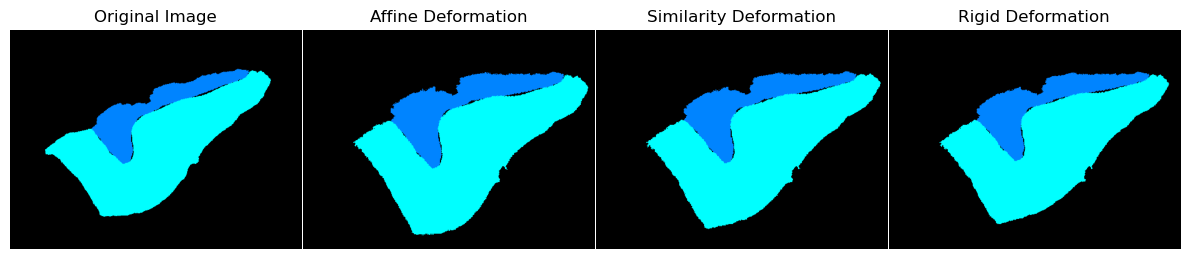

Time (numpy): 9.49270486831665
250


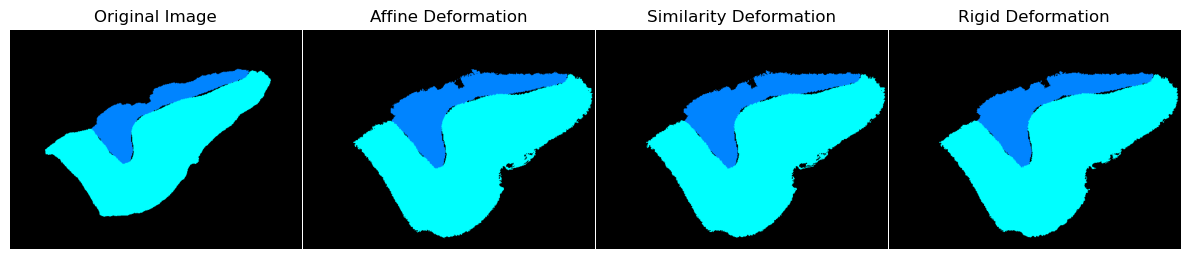

Time (torch): 7.3614397048950195


In [10]:
run_benckmark()

250


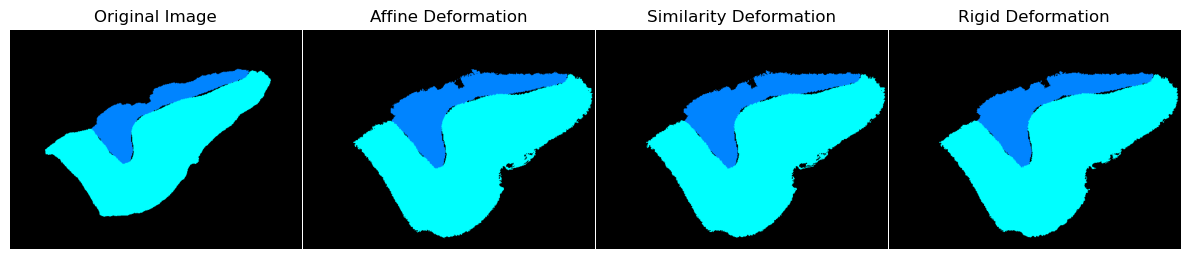

In [11]:
original, res = demo_torch()

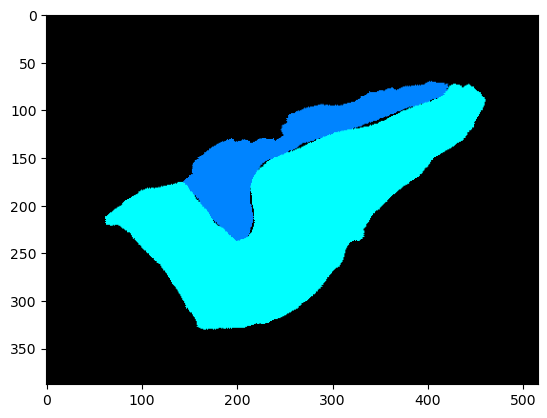

In [12]:
plt.imshow(original)

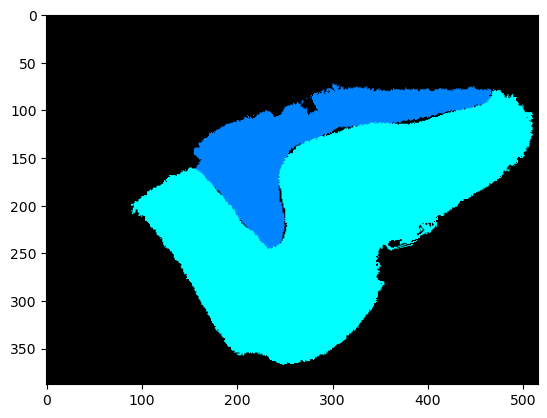

In [13]:
plt.imshow(res)

In [15]:
from rembg import remove
from PIL import Image
from pylab import *
import os
import cv2

# load the M11 matrix
mat_fname_target = os.path.join(r'F:\tumor_measurements\42\2022-09-14_T_HORAO-42-BF_FR_S3_1\polarimetry\650nm', 'MM.npz')
MM = np.load(mat_fname_target)

from skimage import measure

# convert it to a Pillow image
intensity = MM['M11']
intensity = ((intensity * 255) / np.max(intensity)).astype(np.uint8)
intensity = Image.fromarray(intensity)

# remove the background
input = intensity
output = np.array(intensity) > 60

# Creating kernel
kernel = np.ones((12, 12), np.uint8)
output = cv2.erode(output.astype(np.uint8), kernel) 
output = cv2.dilate(output.astype(np.uint8), kernel)

# REPLACE in function
c = measure.find_contours(output, fully_connected = 'high')

contoured = np.zeros(output.shape)

for cont in c:
    for pt in cont:
        contoured[math.ceil(pt[0]), math.ceil(pt[1])] = 1

contour_filtered = contoured

intensity_mask = output

In [16]:
original_mask = np.zeros(original.shape[:2])

for idx, x in enumerate(original):
    for idy, y in enumerate(x):
        if sum(y) != 0:
            original_mask[idx, idy] = 1

In [17]:
res_mask = np.zeros(res.shape[:2])

for idx, x in enumerate(res):
    for idy, y in enumerate(x):
        if sum(y) != 0:
            res_mask[idx, idy] = 1

In [18]:
entire_area = sum(sum(res_mask >= 1))

In [19]:
overlapped_after = sum(sum(np.logical_and(res_mask >= 1, res_mask - intensity_mask == 0)))

In [20]:
overlapped_before = sum(sum(np.logical_and(res_mask >= 1, res_mask - original_mask == 0)))

In [21]:
overlapped_after

69383

In [22]:
entire_area

70319

In [23]:
overlapped_before

46336

In [37]:
import json

def load_color_code(color_code_path):
    """
    function to load the color code for the labels

    Parameters
    ----------
    color_code_path : str
        path to the color code file

    Returns
    -------
    color_code : dict
        the color code for the labels
    """
    # load the json file
    f = open(os.path.join(color_code_path),)
    classes = json.load(f)
    
    # color_code = {}
    # for dat in classes:
        # color_code[dat['name']] = {'RGB': ast.literal_eval(dat['color']), 'code': dat['code']}
    return classes


# load the color code used for the annoations
color_code_path = './../temp/colors.json'
color_code = load_color_code(color_code_path)
color_code_path = './../temp/colors_GM_WM.json'
color_code_GM_WM = load_color_code(color_code_path)

In [39]:
color_code_link = {}
color_code_link_GM_WM = {}

for _, codes in color_code.items():
    color_code_link[tuple(codes['RGB'])] = codes['code']
    color_code_link[(0, 0, 0)] = 7
for _, codes in color_code_GM_WM.items():
    color_code_link_GM_WM[tuple(codes['RGB'])] = codes['code']
    color_code_link_GM_WM[(0, 0, 0)] = 7

In [42]:
path_histology_polarimetry = r'F:\tumor_measurements\42\2022-09-14_T_HORAO-42-BF_FR_S3_1\histology\aligned'

In [82]:
from tqdm.notebook import trange, tqdm

def find_nearest_white(nonzero, target):
    """
    find the nearest pixel to target which is in the nonzero array

    Parameters
    ----------
    nonzero : np.array
        the array containing the indexes of the pixels of interest
    target : tuple
        the target pixel coordinates

    Returns
    -------
    nonzero[nearest_index] : tuple
        the closest pixel to target which is in the nonzero array
    """
    distances = (nonzero[:,:,0] - target[0]) ** 2 + (nonzero[:,:,1] - target[1]) ** 2
    nearest_index = np.argmin(distances)
    return nonzero[nearest_index]

def create_the_image_labels_propagated(path_histology_polarimetry, color_code_link, labels_img):
    
    img_polarimetry = np.array(Image.open(os.path.join(path_histology_polarimetry, 'polarimetry_650.png')))
    labels = np.array(labels_img)
    labels_L = np.array(labels_img.convert('L'))
    img_labels_propagated = np.zeros(labels.shape)
    
    mask = np.zeros(labels.shape)
    nonzero = cv2.findNonZero(labels_L)
    
    path_ROI = os.path.join(path_histology_polarimetry.replace('histology\\aligned', 'annotation'), 'ROI.tif')
    ROI = np.array(Image.open(path_ROI))
    
    for idx, x in tqdm(enumerate(ROI), total = len(ROI)):
        for idy, y in enumerate(x):
            if y == 0:
                pass
            else:
                
                # 1. image labels propagated
                if sum(labels[idx, idy]) == 0:
                    target = (idy, idx)
                    res = find_nearest_white(nonzero, target)
                    idx_min, idy_min = res[0][1], res[0][0]
                    if tuple(labels[idx_min, idy_min]) in color_code_link:
                        img_labels_propagated[idx, idy] = labels[idx_min, idy_min]
                    else:
                        pass
                else:
                    if tuple(labels[idx, idy]) in color_code_link:
                        img_labels_propagated[idx, idy] = labels[idx, idy]
                    else:
                        pass
                    
    return img_labels_propagated

In [83]:
img_labels_propagated = create_the_image_labels_propagated(path_histology_polarimetry, color_code_link, res)
img_labels_propagated = Image.fromarray(img_labels_propagated.astype(np.uint8))

  0%|          | 0/388 [00:00<?, ?it/s]

In [84]:
background = img_labels_propagated
overlay = intensity

background = background.convert("RGBA")
overlay = overlay.convert("RGBA")

new_img = Image.blend(background, overlay, 0.5)

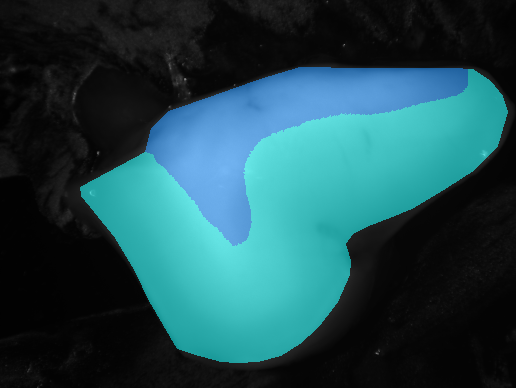

In [85]:
new_img